<a href="https://colab.research.google.com/github/astghiksar/Linear-Algebra-in-Recommendation-Systems-/blob/main/Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Representation


In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt


In [ ]:
# Load the ratings data

ratings = pd.read_csv("ml-latest-small/ratings.csv")

print("Total rows (ratings):", len(ratings))
print("Unique users:", ratings["userId"].nunique())
print("Unique movies:", ratings["movieId"].nunique())
print(ratings.head())


Total rows (ratings): 100836
Unique users: 610
Unique movies: 9724
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [ ]:
top_users = ratings["userId"].value_counts().head(200).index
top_movies = ratings["movieId"].value_counts().head(1000).index

ratings_sub = ratings[
    ratings["userId"].isin(top_users) &
    ratings["movieId"].isin(top_movies)
].copy()

print("Subset rows (ratings):", len(ratings_sub))
print("Subset unique users:", ratings_sub["userId"].nunique())
print("Subset unique movies:", ratings_sub["movieId"].nunique())


Subset rows (ratings): 44208
Subset unique users: 200
Subset unique movies: 1000


In [ ]:
# Linear algebra structure: define R ∈ R^{m×n} with index mappings

user_ids = np.array(sorted(ratings_sub["userId"].unique()))
movie_ids = np.array(sorted(ratings_sub["movieId"].unique()))

user2idx = {u: i for i, u in enumerate(user_ids)}
movie2idx = {m: j for j, m in enumerate(movie_ids)}

m, n = len(user_ids), len(movie_ids)
print("Matrix dimensions (m users, n movies):", (m, n))


Matrix dimensions (m users, n movies): (200, 1000)


In [ ]:
# 4) Build Ω (set of known ratings) and CSR matrix R
rows = ratings_sub["userId"].map(user2idx).to_numpy()
cols = ratings_sub["movieId"].map(movie2idx).to_numpy()
vals = ratings_sub["rating"].to_numpy()

# Ω: observed (u,i) pairs
Omega = list(zip(rows, cols))
print("Size of Ω (known ratings):", len(Omega))

# R: sparse user–movie rating matrix
R = csr_matrix((vals, (rows, cols)), shape=(m, n))

print("R shape (users, movies):", R.shape)
print("Number of non-zero entries (R.nnz):", R.nnz)

Size of Ω (known ratings): 44208
R shape (users, movies): (200, 1000)
Number of non-zero entries (R.nnz): 44208


In [ ]:
# Compute sparsity

total_entries = R.shape[0] * R.shape[1]
sparsity = 1 - (R.nnz / total_entries)

print(f"Total possible entries: {total_entries}")
print(f"Sparsity: {sparsity:.2%}")

Total possible entries: 200000
Sparsity: 77.90%


Top-left 10×10 block (0 means missing):
[[4.  0.  4.  0.  4.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  4.  5.  5.  4.  4.  3.  4.  4.  4. ]
 [4.5 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [2.5 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [3.5 3.  0.  0.  4.  0.  0.  0.  4.5 0. ]
 [4.  3.  3.  0.  0.  2.  2.  0.  0.  0. ]
 [0.  3.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [3.5 3.5 0.  0.  0.  0.  5.  0.  0.  0. ]]


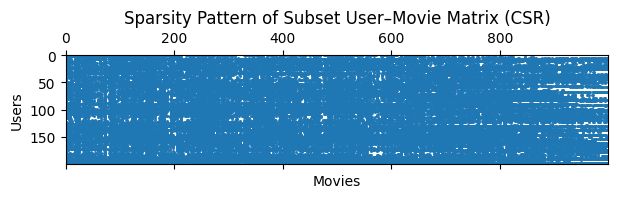

In [33]:
print("Top-left 10×10 block (0 means missing):")
print(R[:10, :10].toarray())

# Sparsity pattern plot
plt.figure(figsize=(7, 5))
plt.spy(R, markersize=1)
plt.title("Sparsity Pattern of Subset User–Movie Matrix (CSR)")
plt.xlabel("Movies")
plt.ylabel("Users")
plt.show()

# Matrix Factorization


In [ ]:
# observed triples (u_idx, i_idx, rating)
data = np.vstack([rows, cols, vals]).T  # shape: (|Ω|, 3)

# shuffle + split
rng = np.random.default_rng(42)
rng.shuffle(data)

test_ratio = 0.2
cut = int(len(data) * (1 - test_ratio))
train_data = data[:cut]
test_data  = data[cut:]

print("Train size:", len(train_data), "Test size:", len(test_data))

Train size: 35366 Test size: 8842


In [ ]:
# Matrix Factorization
def rmse_on_data(P, Q, data):

    u = data[:, 0].astype(int)
    i = data[:, 1].astype(int)
    r = data[:, 2].astype(float)
    pred = np.sum(P[u] * Q[i], axis=1)
    return np.sqrt(np.mean((r - pred) ** 2))


def mf_sgd(train_data, test_data, m, n, k=20, lr=0.01, reg=0.1, epochs=20, seed=42, verbose=True):

    rng = np.random.default_rng(seed)
    P = 0.1 * rng.standard_normal((m, k))
    Q = 0.1 * rng.standard_normal((n, k))

    train_data = train_data.copy()
    history = []

    for epoch in range(1, epochs + 1):
        rng.shuffle(train_data)

        for (u, i, r) in train_data:
            u = int(u); i = int(i); r = float(r)

            # prediction + error
            pred_ui = P[u].dot(Q[i])
            err = r - pred_ui

            # keep a copy of p_u for updating q_i correctly
            p_u_old = P[u].copy()

            # SGD updates
            P[u] += lr * (err * Q[i] - reg * P[u])
            Q[i] += lr * (err * p_u_old - reg * Q[i])

        train_rmse = rmse_on_data(P, Q, train_data)
        test_rmse  = rmse_on_data(P, Q, test_data)
        history.append((epoch, train_rmse, test_rmse))

        if verbose:
            print(f"Epoch {epoch:02d} | Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")

    return P, Q, np.array(history)


In [35]:
k = 30         # latent dimension
lr = 0.02      # learning rate
reg = 0.1     # regularization (lambda)
epochs = 25

P, Q, hist = mf_sgd(train_data, test_data, m, n, k=k, lr=lr, reg=reg, epochs=epochs)


Epoch 01 | Train RMSE: 1.0296 | Test RMSE: 1.0819
Epoch 02 | Train RMSE: 0.8184 | Test RMSE: 0.8569
Epoch 03 | Train RMSE: 0.8081 | Test RMSE: 0.8512
Epoch 04 | Train RMSE: 0.8043 | Test RMSE: 0.8471
Epoch 05 | Train RMSE: 0.7944 | Test RMSE: 0.8383
Epoch 06 | Train RMSE: 0.7904 | Test RMSE: 0.8367
Epoch 07 | Train RMSE: 0.7772 | Test RMSE: 0.8356
Epoch 08 | Train RMSE: 0.7728 | Test RMSE: 0.8314
Epoch 09 | Train RMSE: 0.7590 | Test RMSE: 0.8288
Epoch 10 | Train RMSE: 0.7475 | Test RMSE: 0.8239
Epoch 11 | Train RMSE: 0.7412 | Test RMSE: 0.8255
Epoch 12 | Train RMSE: 0.7296 | Test RMSE: 0.8211
Epoch 13 | Train RMSE: 0.7228 | Test RMSE: 0.8224
Epoch 14 | Train RMSE: 0.7148 | Test RMSE: 0.8218
Epoch 15 | Train RMSE: 0.7039 | Test RMSE: 0.8161
Epoch 16 | Train RMSE: 0.6989 | Test RMSE: 0.8161
Epoch 17 | Train RMSE: 0.6914 | Test RMSE: 0.8184
Epoch 18 | Train RMSE: 0.6825 | Test RMSE: 0.8153
Epoch 19 | Train RMSE: 0.6746 | Test RMSE: 0.8149
Epoch 20 | Train RMSE: 0.6706 | Test RMSE: 0.8145


In [36]:
def predict_rating(P, Q, u_idx, i_idx, clip=True):
    pred = float(P[u_idx].dot(Q[i_idx]))
    if clip:
        pred = min(5.0, max(0.5, pred))
    return pred

# example: predict for first test row
u0, i0, r0 = test_data[0]
print("True:", r0, "Pred:", predict_rating(P, Q, int(u0), int(i0)))


True: 4.0 Pred: 3.1150286578676365


In [38]:
best_epoch = hist[np.argmin(hist[:, 2])]
print("Best Epoch:", int(best_epoch[0]))
print("Best Train RMSE:", best_epoch[1])
print("Best Test RMSE:", best_epoch[2])


Best Epoch: 24
Best Train RMSE: 0.6401903396304512
Best Test RMSE: 0.8072880880053195


# Visualisation


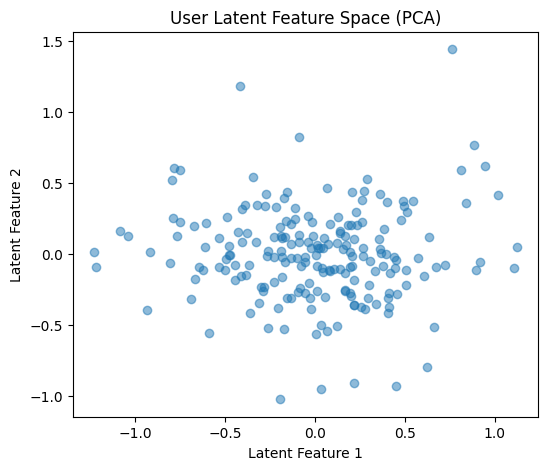

In [39]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce user latent vectors to 2D
pca = PCA(n_components=2)
P_2d = pca.fit_transform(P)

plt.figure(figsize=(6, 5))
plt.scatter(P_2d[:, 0], P_2d[:, 1], alpha=0.5)
plt.xlabel("Latent Feature 1")
plt.ylabel("Latent Feature 2")
plt.title("User Latent Feature Space (PCA)")
plt.show()


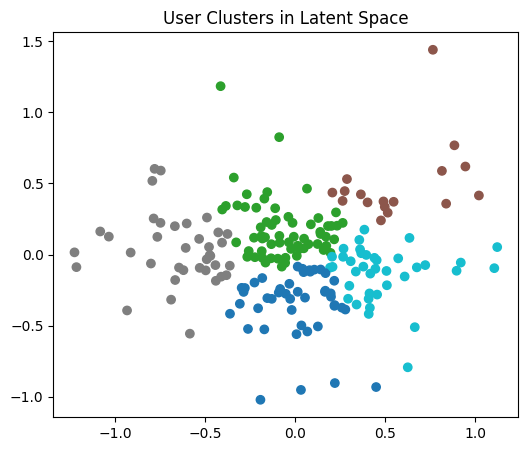

In [40]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(P_2d)

plt.figure(figsize=(6, 5))
plt.scatter(P_2d[:, 0], P_2d[:, 1], c=labels, cmap="tab10")
plt.title("User Clusters in Latent Space")
plt.show()


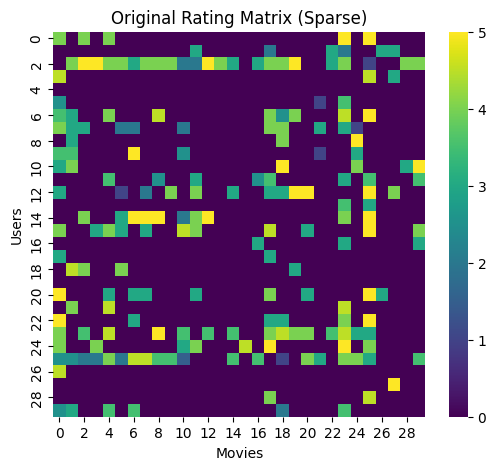

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# take a small block
R_dense = R.toarray()
R_small = R_dense[:30, :30]

plt.figure(figsize=(6, 5))
sns.heatmap(R_small, cmap="viridis")
plt.title("Original Rating Matrix (Sparse)")
plt.xlabel("Movies")
plt.ylabel("Users")
plt.show()


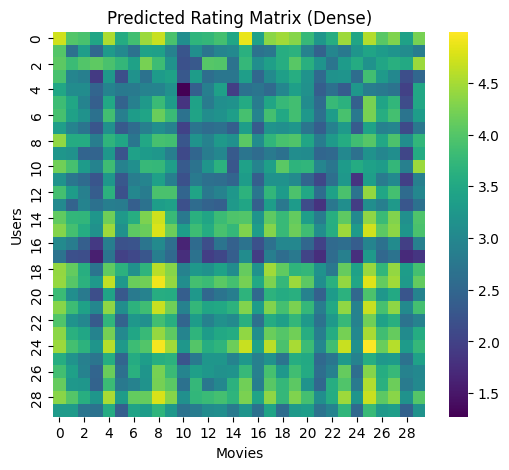

In [42]:
R_hat = P @ Q.T
R_hat_small = R_hat[:30, :30]

plt.figure(figsize=(6, 5))
sns.heatmap(R_hat_small, cmap="viridis")
plt.title("Predicted Rating Matrix (Dense)")
plt.xlabel("Movies")
plt.ylabel("Users")
plt.show()
